# Examples: `bunch` 

[In progress]

In [1]:
import importlib
import sys
sys.path.append('..')

from ipywidgets import interact
from ipywidgets import interactive
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
from psdist import ap
import psdist.bunch as psb
import psdist.image as psi
import psdist.plotting as psp
import seaborn as sns

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

In [3]:
state = np.random.RandomState(1950)

In [4]:
n = 6
k = 10000
X = np.zeros((1, n))

_Sigma = np.identity(n)
for i in range(n):
    for j in range(i):
        _Sigma[i, j] = _Sigma[j, i] = state.uniform(-0.2, 0.2)
X = np.vstack([X, state.multivariate_normal(np.zeros(n), _Sigma, size=k)])
for _ in range(4):
    scale = state.uniform(0.5, 1.5, size=n)
    loc = state.uniform(-3.0, 3.0, size=n)
    X = np.vstack([X, state.normal(loc=loc, scale=scale, size=(k, n))])
X = X - np.mean(X, axis=0)

## Corner plot 

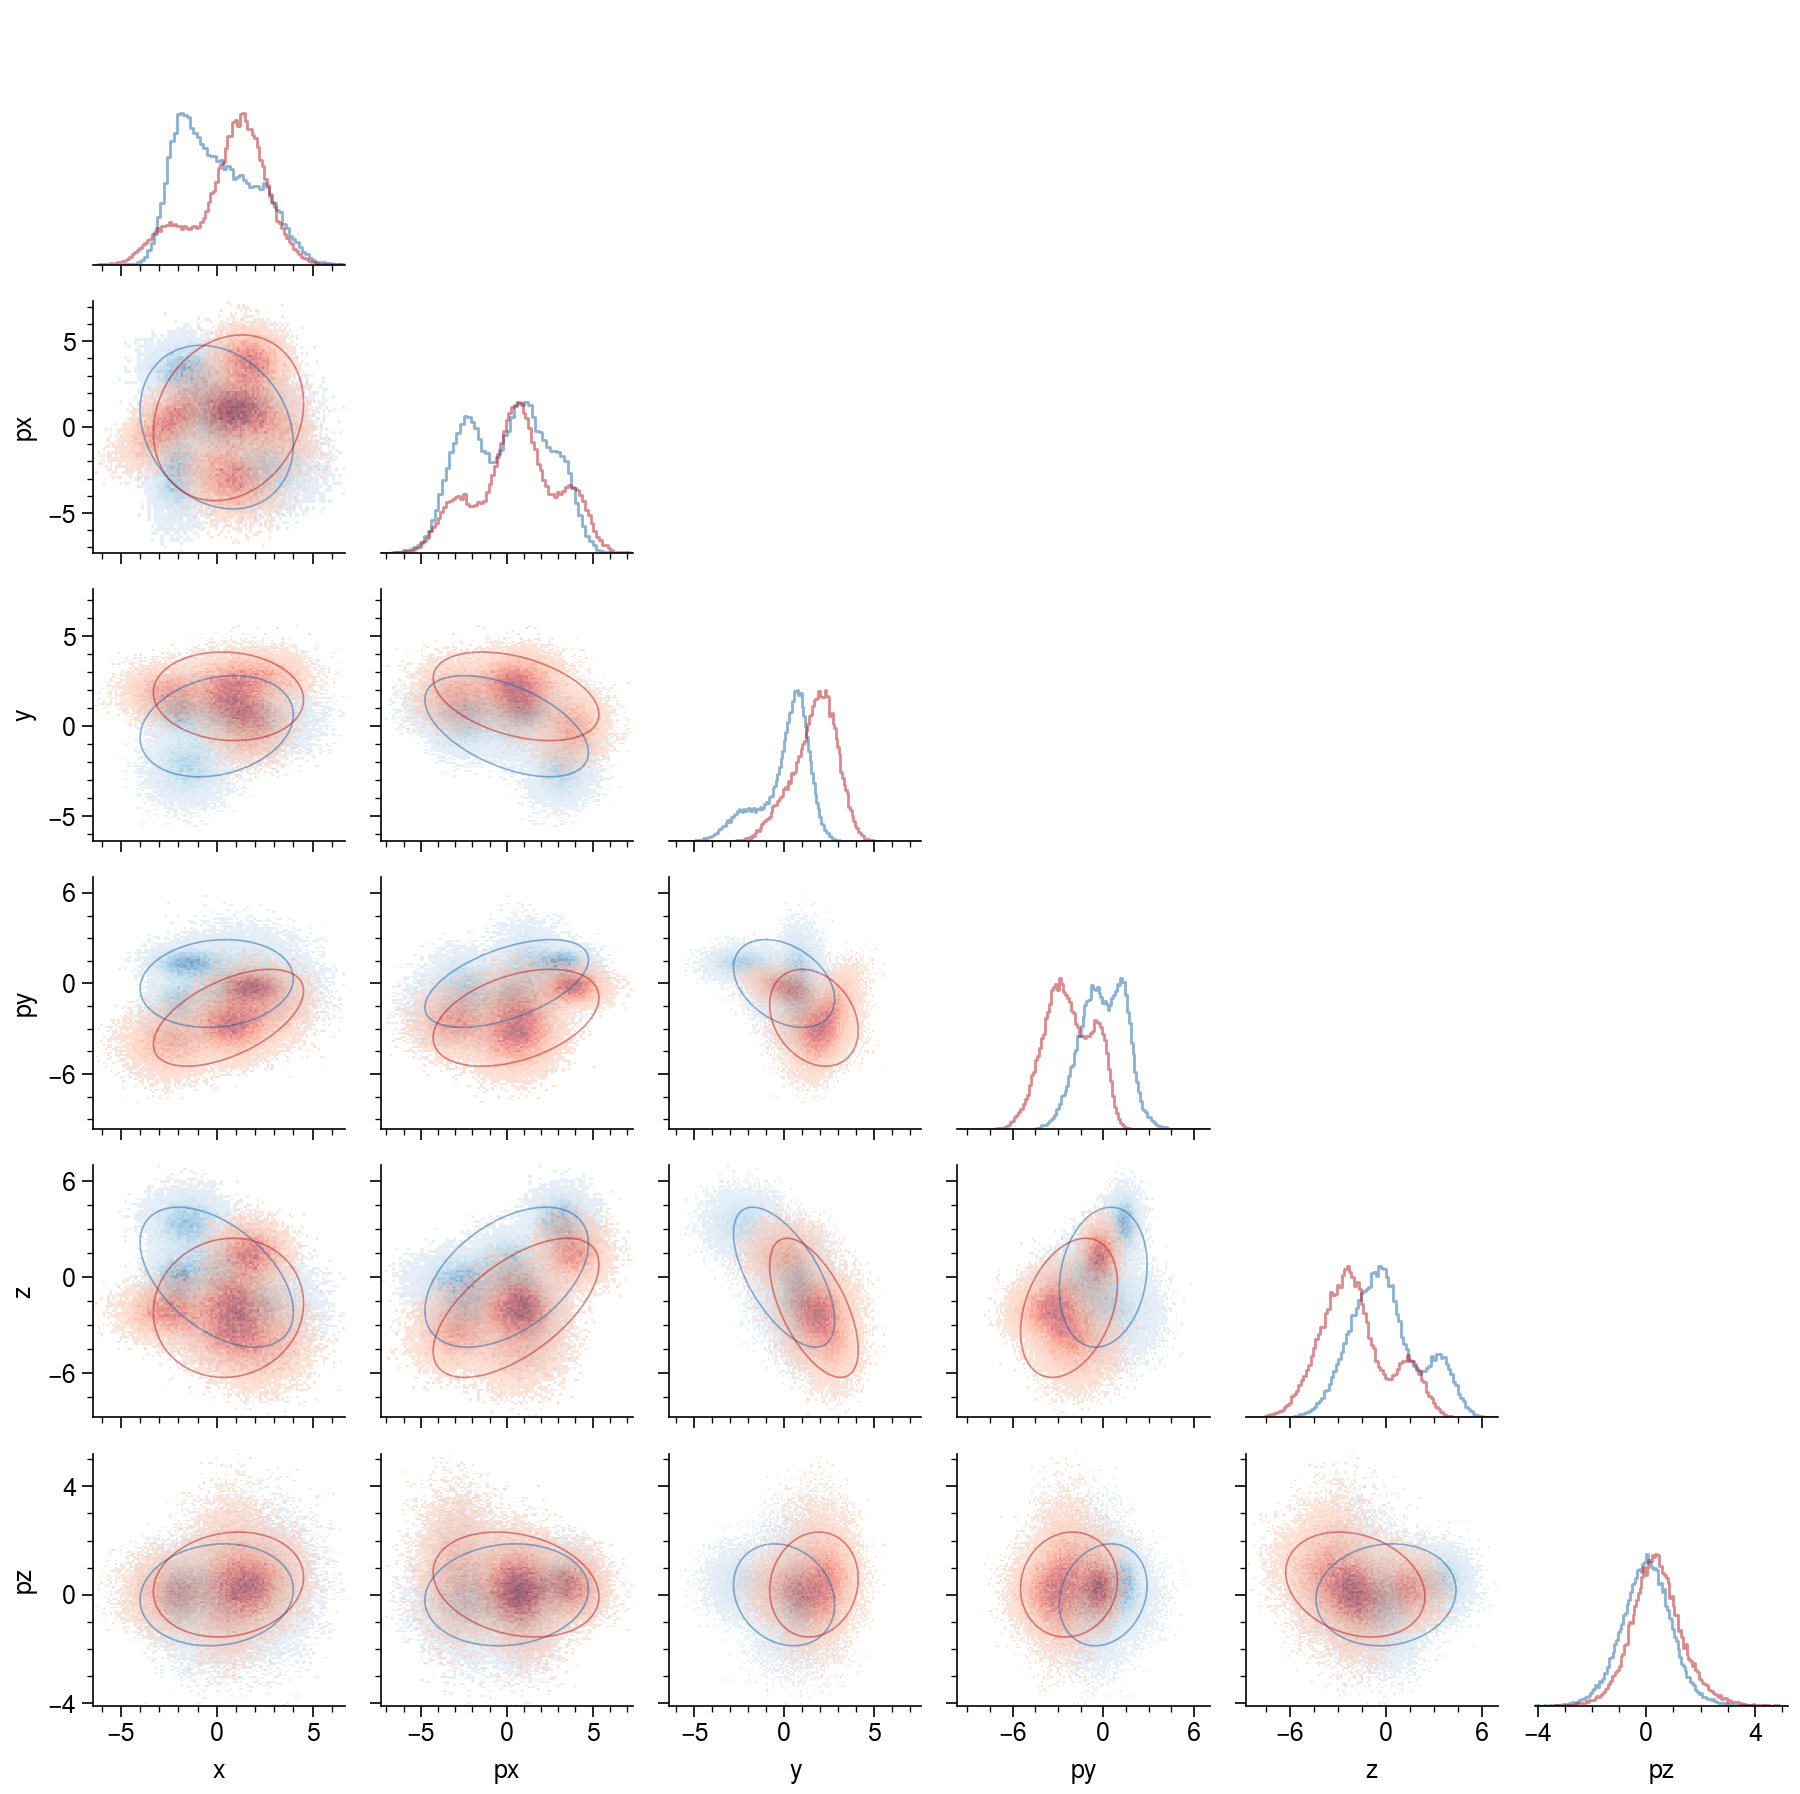

In [5]:
dims = ["x", "px", "y", "py", "z", "pz"]
alpha = 0.5
cmaps = [pplt.Colormap(name, left=0.2) for name in ['blues', 'reds']]
diag_colors = [cmap(0.75) for cmap in cmaps]
diag_kind = 'step'

axes = psp.corner(
    data=X, 
    bins='auto',
    kind='hist',
    diag_kind=diag_kind,
    labels=dims,
    diag_kws=dict(color=diag_colors[0], alpha=alpha),
    cmap=cmaps[0],
    alpha=alpha,
    rms_ellipse=True,
    rms_ellipse_kws=dict(level=2.0, color=diag_colors[0], alpha=0.5),
)

R = ap.phase_adv_mat(np.radians(45.0), np.radians(20.0), np.radians(10.0))
axes = psp.corner(
    data=(psb.apply(R, X) + state.uniform(-3.0, 3.0, size=(1, X.shape[1]))),
    axes=axes,
    diag_kind=diag_kind,
    diag_kws=dict(color=diag_colors[1], alpha=alpha),
    autolim_kws=dict(),
    cmap=cmaps[1],
    alpha=alpha,
    rms_ellipse=True,
    rms_ellipse_kws=dict(level=2.0, color=diag_colors[1], alpha=0.5),
)

## Interactive slicing

In [6]:
kws = dict(
    mask_zero=True,
    cmap=pplt.Colormap('blues', left=0.05),
    prof_kws=dict(color='black'),
)
psp.interactive_proj2d_discrete(X, dims=dims, **kws)

interactive(children=(Checkbox(value=False, description='log'), Checkbox(value=False, description='profiles'),…

## 2D plotting

In [7]:
axis = (0, 1)
_dims = [dims[k] for k in axis]
_X = X[:, axis]

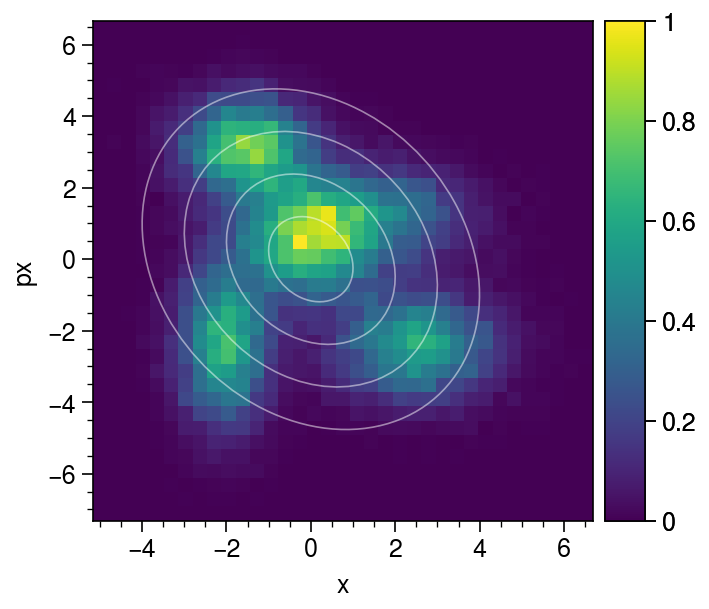

In [8]:
hist, centers = psb.histogram(_X, bins=35, centers=True)

fig, ax = pplt.subplots()
ax = psp.image(
    hist, x=centers[0], y=centers[1], ax=ax, 
    divide_by_max=True,
    colorbar=True,
    rms_ellipse=True,
    rms_ellipse_kws=dict(level=np.arange(0.5, 2.5, 0.5), color='white', alpha=0.5),
    mask_zero=False,
)
ax.format(xlabel=_dims[0], ylabel=_dims[1])
plt.show()

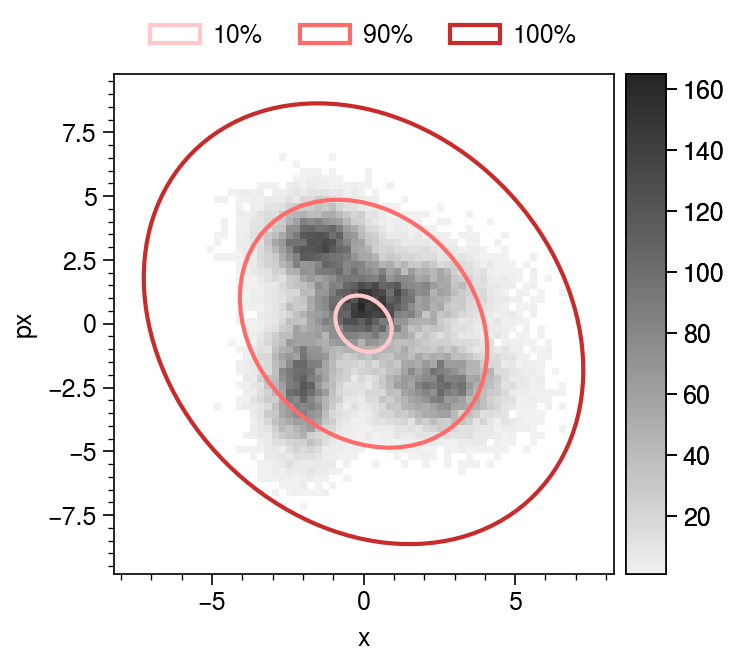

In [9]:
fig, ax = pplt.subplots()
psp.hist2d(
    _X, ax=ax, mask_zero=True, bins=50, 
    colorbar=True, 
    cmap=pplt.Colormap('mono', left=0.05, right=0.85),
)

fractions = [0.10, 0.90, 1.00]
cmap = pplt.Colormap('flare')
colors = [cmap(i) for i in [0.0, 0.5, 1.0]]
colors = ['red2', 'red5', 'red9']
for fraction, color in zip(fractions, colors):
    level = psb.enclosing_ellipsoid(_X, fraction=fraction)
    ax = psp.rms_ellipse(
        Sigma=psb.cov(_X), center=psb.mean(_X), level=level,
        ax=ax,
        color=color, lw=1.5,
        label=f'{(100.0 * fraction):.0f}%',
    )
ax.legend(loc='t', ncols=3, framealpha=0)
ax.format(xlabel=_dims[0], ylabel=_dims[1])